In [1]:
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear,ReLU,Sigmoid,Tanh
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import joblib
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm
import os
from sklearn.utils import shuffle
import random
import os
import pandas as pd
import joblib
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
os.listdir('../data')

['col_names.pkl', 'train.csv', 'PROII20200310']

In [2]:
col_names = joblib.load('../data/col_names.pkl')

In [3]:
df = pd.read_csv('../data/train.csv',index_col=0)
print(df.shape)
print(df.isnull().sum().sum())
df.head()

(16498, 120)
0


,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Heart Cut Product Properties_1,2-Diethylbenzene_wt%",Heart Cut Product Properties_n-Undecane_wt%,Heart Cut Product Properties_n-Pentylbenzene_wt%,Heart Cut Product Properties_n-Dodecane_wt%,Heart Cut Product Properties_n-Hexylbenzene_wt%,Heart Cut Product Properties_n-Tridecane_wt%,Column Temp Profile_C011 Tray 15 Temp_oC,Column Temp Profile_C013 Tray 16 Temp_oC,Duty_Condenser Heat Duty_Mkcal/hr,Duty_Reboiler Heat Duty_Mkcal/hr
001-01,10.0,2.5,100.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.524848,0.147381,0.028986,0.002586,0.005139,0.0,96.623230,165.102661,3.891577,4.252277
001-02,10.0,5.0,100.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.534782,0.150269,0.029559,0.002637,0.005242,0.0,100.645081,164.944336,3.723144,4.071568
001-03,10.0,10.0,100.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.545761,0.153389,0.030175,0.002692,0.005352,0.0,105.073944,164.991577,3.572479,3.900158
001-04,10.0,2.5,100.0,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.544789,0.153849,0.030308,0.002710,0.005391,0.0,96.809662,162.743561,3.442118,3.759819
001-05,10.0,5.0,100.0,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.553923,0.156529,0.030841,0.002758,0.005487,0.0,100.843872,162.590485,3.301176,3.607212


# get X,y

In [4]:
df = shuffle(df)

x_col = col_names['x_col']
y_col = col_names['y_col']

sp1 = int(len(df)*0.7)
sp2 = int(len(df)*0.85)

train = df.iloc[:sp1,:]
valid = df.iloc[sp1:sp2,:]
test = df.iloc[sp2:,:]

X_train = train[x_col].values
Y_train = train[y_col].values

X_valid = valid[x_col].values
Y_valid = valid[y_col].values

X_test = test[x_col].values
Y_test = test[y_col].values

print(X_train.shape,X_valid.shape,X_test.shape)
print(Y_train.shape,Y_valid.shape,Y_test.shape)

(11548, 58) (2475, 58) (2475, 58)
(11548, 62) (2475, 62) (2475, 62)


# scale

In [5]:
mm_x = MinMaxScaler().fit(X_train)
mm_y = MinMaxScaler().fit(Y_train)

In [6]:
X_train = mm_x.transform(X_train)
X_valid = mm_x.transform(X_valid)
X_test = mm_x.transform(X_test)

In [7]:
Y_train = mm_y.transform(Y_train)
Y_valid = mm_y.transform(Y_valid)
Y_test = mm_y.transform(Y_test)

# convert to torch tensor

In [8]:
X_train = torch.tensor(X_train,dtype=torch.float).cuda()
X_valid = torch.tensor(X_valid,dtype=torch.float).cuda()
X_test = torch.tensor(X_test,dtype=torch.float).cuda()

Y_train = torch.tensor(Y_train,dtype=torch.float).cuda()
Y_valid = torch.tensor(Y_valid,dtype=torch.float).cuda()
Y_test = torch.tensor(Y_test,dtype=torch.float).cuda()

# data iter

In [9]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

In [10]:
datasets = torch.utils.data.TensorDataset(X_valid, Y_valid)
valid_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# Construct the neural network

In [11]:
class NET(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(NET,self).__init__()
        self.fc1 = Linear(input_shape,128)
        self.fc2 = Linear(128,128)
        self.fc3 = Linear(128,output_shape)
    
    def forward(self,x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [12]:
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0)

In [13]:
net = NET(len(x_col),len(y_col)).cuda()
net.apply(init_weights)

NET(
  (fc1): Linear(in_features=58, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=62, bias=True)
)

In [14]:
net(X_test).shape

torch.Size([2475, 62])

# loss and optimizer

In [15]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

# train_loop

In [16]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 0.0289 valid loss 0.0118
record net
epochs 1 train loss 0.0087 valid loss 0.0065
record net
epochs 2 train loss 0.0053 valid loss 0.0044
record net
epochs 3 train loss 0.0039 valid loss 0.0033
record net
epochs 4 train loss 0.0030 valid loss 0.0027
record net
epochs 5 train loss 0.0024 valid loss 0.0022
record net
epochs 6 train loss 0.0020 valid loss 0.0018
record net
epochs 7 train loss 0.0017 valid loss 0.0016
record net
epochs 8 train loss 0.0016 valid loss 0.0015
record net
epochs 9 train loss 0.0014 valid loss 0.0014
record net
epochs 10 train loss 0.0013 valid loss 0.0013
record net
epochs 11 train loss 0.0012 valid loss 0.0012
record net
epochs 12 train loss 0.0012 valid loss 0.0011
record net
epochs 13 train loss 0.0011 valid loss 0.0011
record net
epochs 14 train loss 0.0011 valid loss 0.0010
record net
epochs 15 train loss 0.0010 valid loss 0.0010
record net
epochs 16 train loss 0.0010 valid loss 0.0009
record net
epochs 17 train loss 0.0009 valid loss 0.

epochs 159 train loss 0.0001 valid loss 0.0002
epochs 160 train loss 0.0001 valid loss 0.0002
epochs 161 train loss 0.0001 valid loss 0.0002
epochs 162 train loss 0.0001 valid loss 0.0002
epochs 163 train loss 0.0001 valid loss 0.0002
epochs 164 train loss 0.0001 valid loss 0.0002
record net
epochs 165 train loss 0.0001 valid loss 0.0002
epochs 166 train loss 0.0001 valid loss 0.0001
record net
epochs 167 train loss 0.0001 valid loss 0.0002
epochs 168 train loss 0.0001 valid loss 0.0002
epochs 169 train loss 0.0001 valid loss 0.0001
epochs 170 train loss 0.0001 valid loss 0.0001
record net
epochs 171 train loss 0.0001 valid loss 0.0002
epochs 172 train loss 0.0001 valid loss 0.0001
epochs 173 train loss 0.0001 valid loss 0.0002
epochs 174 train loss 0.0001 valid loss 0.0002
epochs 175 train loss 0.0001 valid loss 0.0002
epochs 176 train loss 0.0001 valid loss 0.0002
epochs 177 train loss 0.0001 valid loss 0.0001
epochs 178 train loss 0.0001 valid loss 0.0001
record net
epochs 179 train

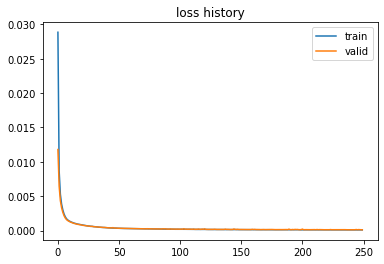

In [17]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=250)

# make prediction

In [18]:
y_pred = net(X_test).cpu().detach().numpy()
y_pred = mm_y.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_pred.head()

,Naphtha Properties_Naphtha Feed Rate_m3/hr,Yield Summary_Reflux Rate_m3/hr,Yield Summary_Light End Prod. Rate_m3/hr,Yield Summary_Heavy End Prod. Rate_m3/hr,Heart Cut Product Properties_Oxygen_wt%,Heart Cut Product Properties_Methane_wt%,Heart Cut Product Properties_Ethane_wt%,Heart Cut Product Properties_Propane_wt%,Heart Cut Product Properties_n-Butane_wt%,Heart Cut Product Properties_i-Pentane_wt%,...,"Heart Cut Product Properties_1,2-Diethylbenzene_wt%",Heart Cut Product Properties_n-Undecane_wt%,Heart Cut Product Properties_n-Pentylbenzene_wt%,Heart Cut Product Properties_n-Dodecane_wt%,Heart Cut Product Properties_n-Hexylbenzene_wt%,Heart Cut Product Properties_n-Tridecane_wt%,Column Temp Profile_C011 Tray 15 Temp_oC,Column Temp Profile_C013 Tray 16 Temp_oC,Duty_Condenser Heat Duty_Mkcal/hr,Duty_Reboiler Heat Duty_Mkcal/hr
0,121.980972,38.273552,11.522946,10.704687,0.000091,0.000208,0.000217,0.000292,0.001361,0.022172,...,0.540320,0.207915,0.029340,0.003764,0.005665,0.000188,98.205803,159.093079,3.438443,3.626355
1,119.209396,34.179756,7.414654,11.467777,0.000311,0.000519,0.000147,0.001213,0.005739,0.095684,...,0.684737,0.071550,0.038491,0.001253,0.007259,0.000584,97.821030,136.822449,2.760463,2.511611
2,106.211075,43.242001,5.992714,8.271306,0.000093,0.000109,0.000146,0.000056,0.000237,0.003853,...,0.342195,0.120182,0.018144,0.002037,0.003591,0.000146,97.050865,164.107880,3.471336,3.811301
3,116.447334,39.692551,7.375380,9.025547,0.000104,0.000140,0.000110,0.000489,0.002217,0.035088,...,0.189748,0.036225,0.010835,0.000885,0.002104,0.000121,104.112389,151.159210,3.188538,3.343508
4,110.646019,48.271629,12.246256,8.727369,0.000061,0.000074,0.000113,0.000269,0.001256,0.020437,...,0.683347,0.132351,0.036834,0.002118,0.007285,0.000107,95.981705,163.209900,4.210768,4.271513


In [19]:
y_real = Y_test.cpu().detach().numpy()
y_real = mm_y.inverse_transform(y_real)
y_real = pd.DataFrame(y_real,columns=y_col)
y_real.head()

,Naphtha Properties_Naphtha Feed Rate_m3/hr,Yield Summary_Reflux Rate_m3/hr,Yield Summary_Light End Prod. Rate_m3/hr,Yield Summary_Heavy End Prod. Rate_m3/hr,Heart Cut Product Properties_Oxygen_wt%,Heart Cut Product Properties_Methane_wt%,Heart Cut Product Properties_Ethane_wt%,Heart Cut Product Properties_Propane_wt%,Heart Cut Product Properties_n-Butane_wt%,Heart Cut Product Properties_i-Pentane_wt%,...,"Heart Cut Product Properties_1,2-Diethylbenzene_wt%",Heart Cut Product Properties_n-Undecane_wt%,Heart Cut Product Properties_n-Pentylbenzene_wt%,Heart Cut Product Properties_n-Dodecane_wt%,Heart Cut Product Properties_n-Hexylbenzene_wt%,Heart Cut Product Properties_n-Tridecane_wt%,Column Temp Profile_C011 Tray 15 Temp_oC,Column Temp Profile_C013 Tray 16 Temp_oC,Duty_Condenser Heat Duty_Mkcal/hr,Duty_Reboiler Heat Duty_Mkcal/hr
0,121.999985,38.159966,11.456052,10.545206,0.0,0.0,0.0,0.000288,0.001342,0.022087,...,0.547759,0.210912,0.030805,0.003621,0.005755,0.0,98.166748,158.373108,3.425088,3.574847
1,120.000008,36.500763,8.232948,11.766957,0.0,0.0,0.0,0.001228,0.005806,0.097181,...,0.652080,0.069023,0.037268,0.001480,0.007374,0.0,97.653961,133.874359,2.936057,2.712326
2,104.800003,42.822109,6.266923,8.532764,0.0,0.0,0.0,0.000059,0.000281,0.004542,...,0.340415,0.117030,0.018917,0.001922,0.003817,0.0,97.015320,163.749725,3.475713,3.820400
3,116.500015,39.786442,7.148939,9.351106,0.0,0.0,0.0,0.000494,0.002254,0.035770,...,0.208518,0.034127,0.011707,0.000680,0.002029,0.0,104.191589,150.861328,3.196918,3.371924
4,110.880005,47.866077,12.276336,8.602918,0.0,0.0,0.0,0.000277,0.001254,0.020449,...,0.682186,0.131196,0.037805,0.001956,0.007118,0.0,95.840057,163.401123,4.168175,4.227760


# metric

In [20]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
res = pd.DataFrame(index=y_col,columns=['MSE','MAPE'])

for i in y_col:
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,MSE,MAPE
Naphtha Properties_Naphtha Feed Rate_m3/hr,0.792314,0.40054
Yield Summary_Reflux Rate_m3/hr,5.9231,2.34566
Yield Summary_Light End Prod. Rate_m3/hr,0.082822,6.32764
Yield Summary_Heavy End Prod. Rate_m3/hr,0.395445,2.80312
Heart Cut Product Properties_Oxygen_wt%,2.4603e-08,inf
...,...,...
Column Temp Profile_C011 Tray 15 Temp_oC,0.0859163,0.195003
Column Temp Profile_C013 Tray 16 Temp_oC,1.55633,0.368927
Duty_Condenser Heat Duty_Mkcal/hr,0.0361403,2.1579
Duty_Reboiler Heat Duty_Mkcal/hr,0.0385615,2.09735


# WRAP MODEL

In [22]:
class NET_wrapper(object):
    def __init__(self):
        self.x_col = x_col
        self.y_col = y_col
        self.mm_x = mm_x
        self.mm_y = mm_y
        self.net = net.eval()
    
    def predict(self,x):
        x = self.mm_x.transform(x)
        x = torch.tensor(x,dtype=torch.float).cuda()
        y = self.net(x).detach().cpu().numpy()
        y = self.mm_y.inverse_transform(y)
        y = pd.DataFrame(y,columns=self.y_col)
        y.iloc[:,4:4+54] /= y.iloc[:,4:4+54].sum(axis=1).values.reshape(-1,1)
        y.iloc[:,4:4+54] *= 100
        return y

In [23]:
model = NET_wrapper()

In [24]:
df = df.sample(1000)
x = df[x_col]
y_real = df[y_col]
y_pred = model.predict(x)

In [25]:
res = pd.DataFrame(index=y_col,columns=['MSE','MAPE'])

for i in y_col:
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,MSE,MAPE
Naphtha Properties_Naphtha Feed Rate_m3/hr,0.632959,0.3929
Yield Summary_Reflux Rate_m3/hr,4.62819,2.37858
Yield Summary_Light End Prod. Rate_m3/hr,0.0811588,3.74996
Yield Summary_Heavy End Prod. Rate_m3/hr,0.237244,2.89748
Heart Cut Product Properties_Oxygen_wt%,2.46359e-08,inf
...,...,...
Column Temp Profile_C011 Tray 15 Temp_oC,0.0886995,0.195819
Column Temp Profile_C013 Tray 16 Temp_oC,1.3659,0.366805
Duty_Condenser Heat Duty_Mkcal/hr,0.0267741,2.13428
Duty_Reboiler Heat Duty_Mkcal/hr,0.0288282,2.06587
